# О чем файл?

В данном файле проводится анализ данных, поиск различных инсайтов -- EDA.

## 1) Библиотеки и данные

In [5]:
#импорт библиотек
%matplotlib inline
import pandas as pd
import seaborn as sns
import datetime as dt
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy.sparse as sparse
import numpy as np
import apyori
from apyori import apriori
import lightfm
from lightfm import LightFM
from lightfm.evaluation import reciprocal_rank, auc_score, precision_at_k

import warnings
warnings.filterwarnings('ignore')

In [7]:
#данные
data = pd.read_csv('/work/data.csv', sep = ";")
data.head(3)

,dt,tr_id,cl_id,ar_id,qty,s
0,2007-05-03 21:43:33,954,1,2873,1.0,8150.0
1,2007-11-20 20:46:41,13796,1,3585,1.0,3930.0
2,2007-12-08 16:28:59,14431,1,4940,1.0,2860.0


У нас есть информация о покупках клиентов с переменными:

- dt - время покупки

- tr_id - id покупки

- cl_id - id клиента

- ar_id - id товара

- qty - купленных предметов

цена покупки данного товара.

## 2) Знакомлюсь с данными. Очистка данных.

In [8]:
for_prediction = data[data["ar_id"].isnull()]
data = data[~data["ar_id"].isnull()]

In [9]:
data.shape

(48303, 6)

6 столбцов (переменных) и 48303 строк (записей).

In [10]:
data.dtypes

dt        object
tr_id      int64
cl_id      int64
ar_id      int64
qty      float64
s        float64
dtype: object

Все числовые, только dt показывает время.

In [11]:
# преобразую тип данных
data["dt"] = pd.to_datetime(data["dt"])
data['qty'] = data['qty'].astype(int)

In [12]:
data.isnull().sum()

dt       0
tr_id    0
cl_id    0
ar_id    0
qty      0
s        0
dtype: int64

In [13]:
data.shape

(48303, 6)

Избавлюсь от дубликатов если они есть.

In [16]:
data = data.drop_duplicates(subset = None, keep = 'first', inplace = False)
data.shape

(47174, 6)

Дубликаты были. Так как изначально было 48303 записи. Удалили 1129 повторных записей.

## 3) Рассмотрю разные переменные.

Рассмотрю качество купленных предметов и цену покупки данного товара.

In [18]:
data[['qty', 's']].describe()

,qty,s
count,47174.0,47174.000000
mean,1.0,10450.925519
std,0.0,12698.798849
min,1.0,504.000000
25%,1.0,3805.000000
50%,1.0,6900.000000
75%,1.0,12747.492500
max,1.0,511500.000000


Интересно, а какая средняя цена покупки?

In [19]:
#Перед этим проверка на отрицательные значения
data.min()

dt       2007-03-12 18:50:49
tr_id                      1
cl_id                      1
ar_id                      1
qty                        1
s                      504.0
dtype: object

In [20]:
#Средняя цена
data['s'].mean()

10450.925518505957

Посмотрим на распределение цены.

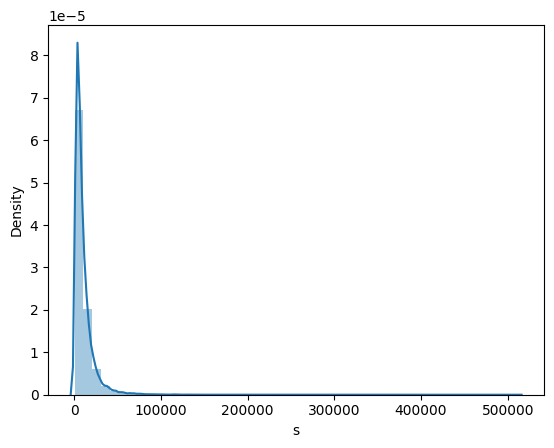

In [21]:
ax = sns.distplot(data["s"].astype(int))

In [22]:
data['date'] = data['dt'].dt.date
data2 = data[['s', 'date']].groupby("date").sum().sort_values("date", ascending = True)
data2.reset_index(drop = False, inplace = True)

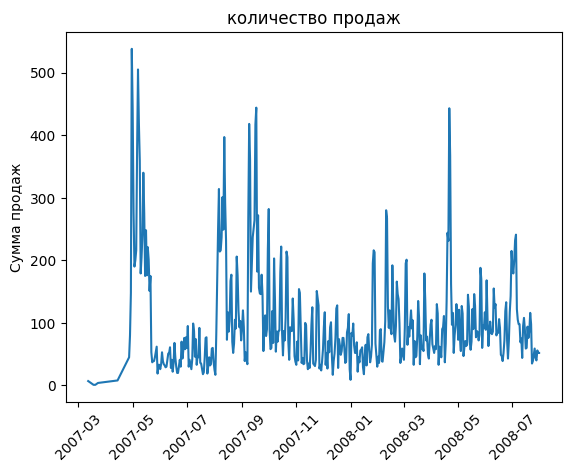

In [25]:
plt.plot(data2["date"], data2['s'])
plt.title('количество продаж')
plt.ylabel('Сумма продаж')
plt.xticks(rotation = 45)
plt.show()

In [24]:
data2 = data[['s', 'date']].groupby("date").count().sort_values("date", ascending = True)
data2.reset_index(drop = False, inplace = True)

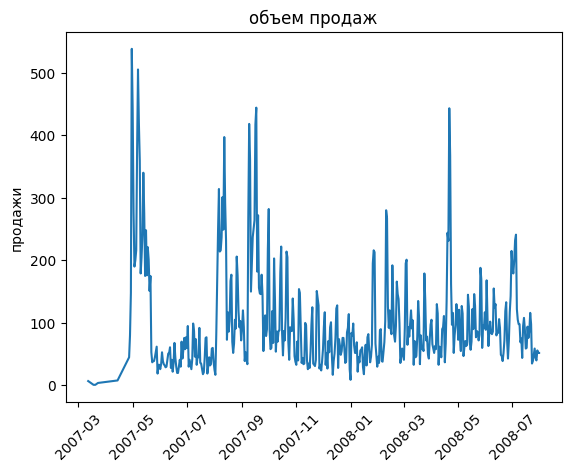

In [26]:
plt.plot(data2["date"], data2['s'])
plt.title('объем продаж')
plt.ylabel('продажи')
plt.xticks(rotation = 45)
plt.show()

Интересно, а что с продажами по часам?

Text(0.5, 1.0, 'Продажи в час')

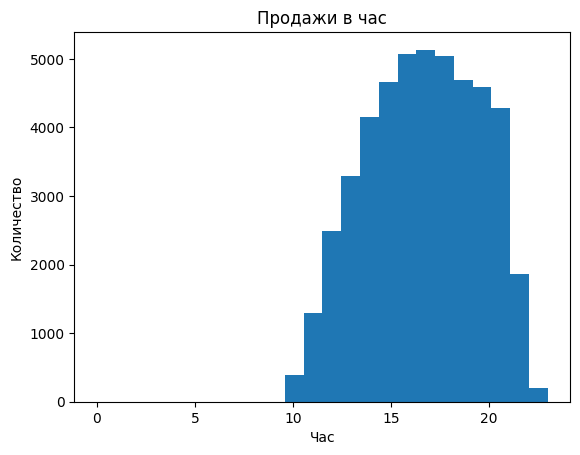

In [27]:
plt.hist(data['dt'].dt.hour.values, bins=24)
plt.xlabel('Час')
plt.ylabel('Количество')
plt.title('Продажи в час')

Продажи начинают расти с первого часа работы. Меньше всего продаж в последний час работы. Вероятнее всего магазин работает с 10:00 до 23:00. Больше всего продаж между 15:00 и 18:00, плюс-минус 5000 продаж в час (но это предварительно).

Какой самый популярный и прибыльный товар?

In [30]:
#самый популярный
popularity = data[['ar_id', 'qty', 's']].groupby("ar_id").sum().sort_values("qty", ascending = False)
popularity.head()

,qty,s
ar_id,,
4942,725,5092324.27
4909,580,1823693.31
3486,435,4566229.85
434,430,1747247.86
2635,425,1211674.74


In [29]:
#самый прибыльный
profitability = data[['ar_id', 'qty', 's']].groupby("ar_id").sum().sort_values("s", ascending = False)
profitability.head()

,qty,s
ar_id,,
3059,156,7114347.53
4755,281,6684277.87
4942,725,5092324.27
3486,435,4566229.85
2430,94,3805189.37


Только один товар попал в оба топа -- "3486". Тут в целом все логично, поскольку какие-то дороже и их покупаю реже, какие-то дешевле, но их покупают чаще. Но прибыль от дорогих и не популярных может быть больше.

Прибыльное время?

In [31]:
time = data[['dt', 's']]
time.set_index('dt', inplace = True)
time.head()

,s
dt,
2007-05-03 21:43:33,8150.0
2007-11-20 20:46:41,3930.0
2007-12-08 16:28:59,2860.0
2007-05-03 21:15:59,4895.0
2007-05-20 16:46:45,840.0


## 4) RFM-анализ

Метод, позволяющий сегментировать клиентов по частоте и сумме покупок и выявлять тех клиентов, которые приносят больше денег. 

- Recency — давность (как давно ваши пользователи что-то у вас покупали);

- Frequency — частота (как часто они у вас покупают);

- Monetary — прибыль (общая сумма покупок).

In [32]:
rfm = data.groupby(['tr_id'])['qty', 's'].sum()
rfm.reset_index(drop = False, inplace = True)
rfm = pd.merge(rfm, data[['cl_id', 'dt', 'tr_id']], how = 'inner', on = 'tr_id')
rfm = rfm.drop_duplicates(subset = None, keep = 'first', inplace = False)

In [33]:
rfm.head()

,tr_id,qty,s,cl_id,dt
0,1,2,21365.0,4526,2007-03-12 18:50:49
2,2,2,16423.0,4526,2007-03-12 18:52:29
4,3,2,10915.0,4526,2007-03-12 18:54:39
6,4,1,4495.0,4526,2007-03-12 18:56:35
7,5,1,15050.0,2637,2007-03-18 17:26:00


In [35]:
last = dt.datetime(2008, 8, 1) # последний день в данных

rfm = rfm.groupby('cl_id').agg({'dt': lambda x: (last - x.max()).days,      # давность
                                        'tr_id': lambda x: len(x),         # частота
                                        's': lambda x: x.sum()})           # прибыль

rfm['dt'] = rfm['dt'].astype(int)
rfm.rename(columns = {'dt': 'recency', 
                    'tr_id': 'frequency', 
                    's': 'monetary_value'}, inplace=True)


rfm.head()

,recency,frequency,monetary_value
cl_id,,,
1,236,3,14940.0
2,76,4,88540.0
3,455,1,7100.0
4,8,26,351196.5
5,453,1,3035.0


Определение квартилей

In [36]:
quantiles = rfm.quantile(q = [0.25,0.5,0.75]).to_dict()
quantiles

{'recency': {0.25: 83.0, 0.5: 185.0, 0.75: 334.0},
 'frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 2.0},
 'monetary_value': {0.25: 7490.0, 0.5: 17545.0, 0.75: 41490.0}}

In [37]:
# Создание таблицы сегментации RFM
# Аргументы: x=значение, p=повторяемость, прибыль, частота , k = квартили dict)
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [38]:
rfm['R_Quartile'] = rfm['recency'].apply(RClass, args = ('recency', quantiles,))
rfm['F_Quartile'] = rfm['frequency'].apply(FMClass, args = ('frequency', quantiles,))
rfm['M_Quartile'] = rfm['monetary_value'].apply(FMClass, args = ('monetary_value', quantiles,))

rfm['RFMClass'] = rfm.R_Quartile.map(str) + rfm.F_Quartile.map(str) + rfm.M_Quartile.map(str)
rfm.head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
cl_id,,,,,,,
1,236,3,14940.0,3,1,3,313
2,76,4,88540.0,1,1,1,111
3,455,1,7100.0,4,4,4,444
4,8,26,351196.5,1,1,1,111
5,453,1,3035.0,4,4,4,444


Кто 5 лучших покупателей? по RFM-классу 111, покупатели с большими расходами, которые покупают недавно и часто?

In [39]:
rfm[rfm['RFMClass'] == '111'].sort_values('monetary_value', ascending = False).head(5)

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
cl_id,,,,,,,
1572,0,126,6300874.84,1,1,1,111
2177,12,44,3716194.39,1,1,1,111
4997,66,35,3012222.70,1,1,1,111
3738,0,128,2694385.00,1,1,1,111
3799,7,95,2493029.97,1,1,1,111


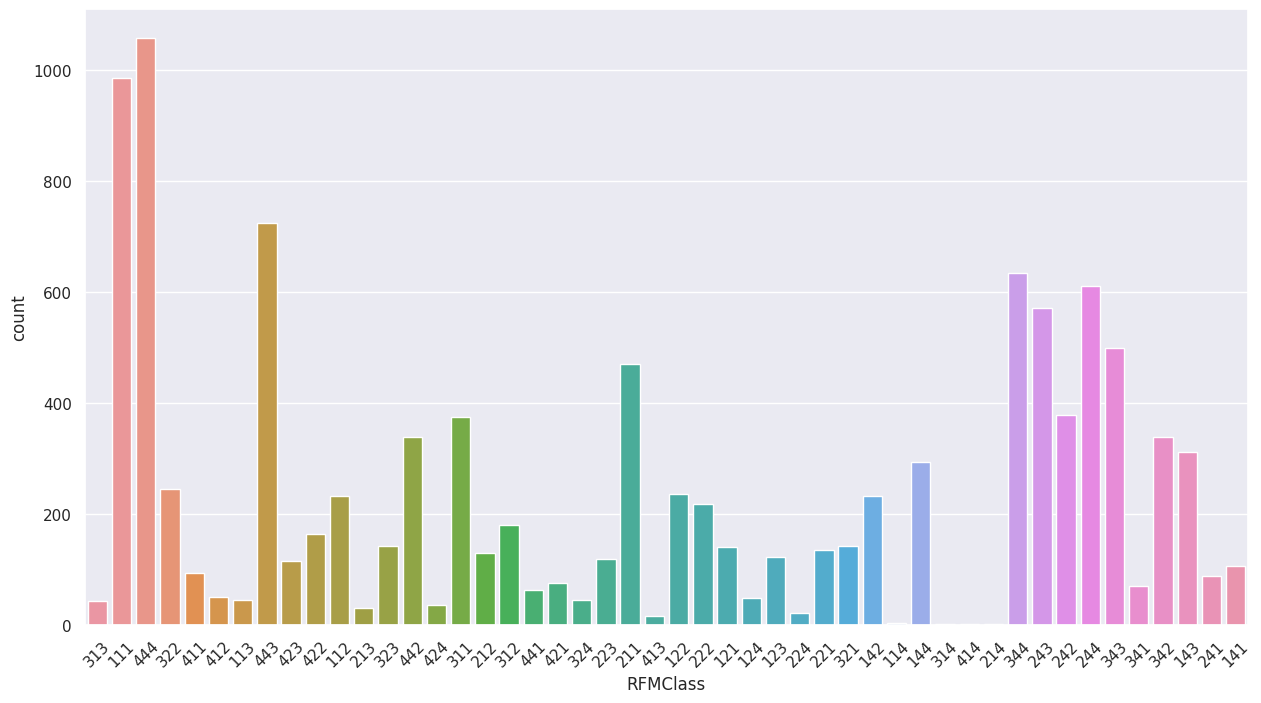

In [40]:
plt.figure(figsize=(15, 8))
sns.set()
ax = sns.countplot(x = "RFMClass", data = rfm)
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)

Найдём ассоциативные правила.

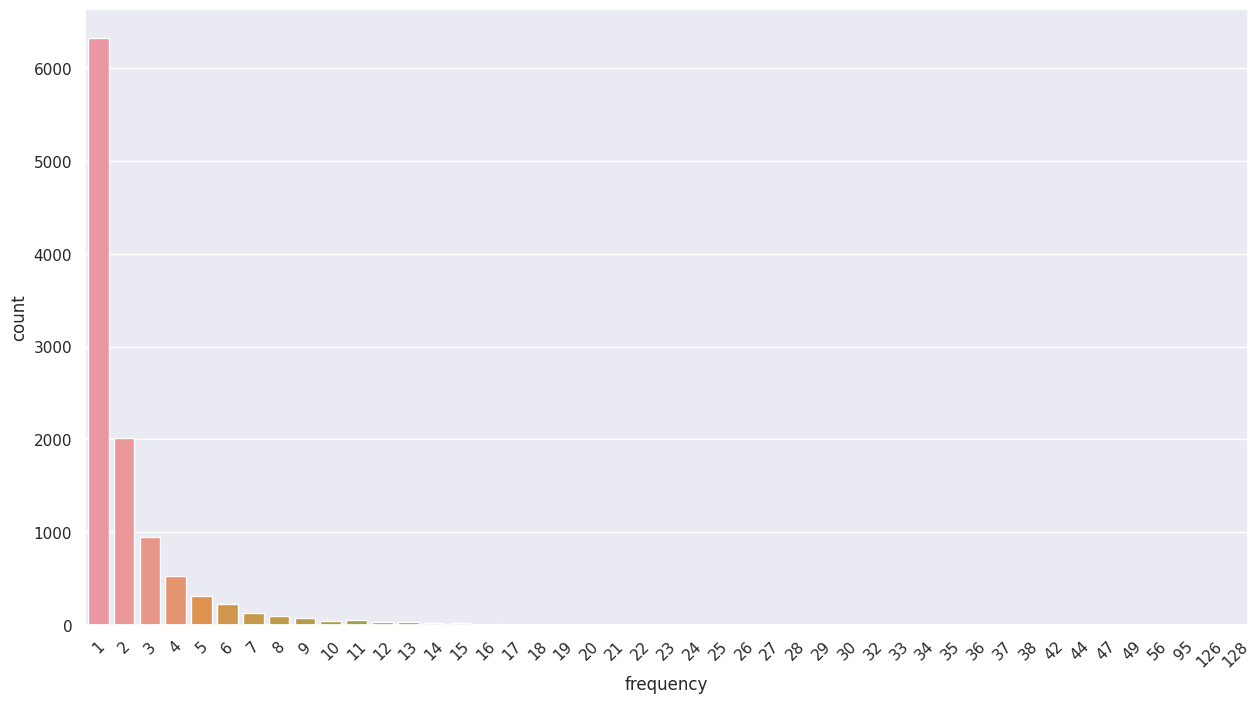

In [41]:
# посмотрим на распределение
plt.figure(figsize=(15, 8))
sns.set()
ax = sns.countplot(x = "frequency", data = rfm)
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)

In [43]:
a = data['ar_id'].value_counts()
print (type(a))
print (a)

<class 'pandas.core.series.Series'>
4942    725
4909    580
3486    435
434     430
2635    425
       ... 
3755      1
1974      1
3787      1
1770      1
2047      1
Name: ar_id, Length: 5292, dtype: int64


In [44]:
apriori = data.groupby('tr_id')['ar_id'].apply(lambda g: g.values.tolist()).to_dict()
apriori = list(apriori.values())

# Макс кол-во элементов в корзине
max(len(elem) for elem in apriori)

27

In [45]:
transactions = []
for i in range(0, len(apriori)):
    n = list(apriori[i])
    for x in range(27):
        n = np.append(n, 'nan')
    transactions.append(n.tolist())

In [46]:
# тренирую
from apyori import apriori
rules = apriori(transactions, min_support = 0.001, min_confidence = 0.01, min_lift = 3, min_length = 2)

# смотрим результат
list(rules)

[RelationRecord(items=frozenset({'2811', '2635'}), support=0.0010991093424294106, ordered_statistics=[OrderedStatistic(items_base=frozenset({'2635'}), items_add=frozenset({'2811'}), confidence=0.07455012853470436, lift=8.16184705970197), OrderedStatistic(items_base=frozenset({'2811'}), items_add=frozenset({'2635'}), confidence=0.12033195020746887, lift=8.16184705970197)]),
 RelationRecord(items=frozenset({'434', '443'}), support=0.001288610953193102, ordered_statistics=[OrderedStatistic(items_base=frozenset({'434'}), items_add=frozenset({'443'}), confidence=0.10725552050473185, lift=17.687105678233436), OrderedStatistic(items_base=frozenset({'443'}), items_add=frozenset({'434'}), confidence=0.2125, lift=17.687105678233436)]),
 RelationRecord(items=frozenset({'434', '471'}), support=0.0015539132082622701, ordered_statistics=[OrderedStatistic(items_base=frozenset({'434'}), items_add=frozenset({'471'}), confidence=0.12933753943217663, lift=14.338533520663782), OrderedStatistic(items_base=

Недостаточно взаимосвязей для создания разумного количества предложений по продуктам -- получилось очень небольшое количество.

## 5) АВС-анализ

Позволит классифицировать ресурсы по степени важности. В основе лежит принцип Парето — 20 % всех товаров дают 80 % оборота. 

In [47]:
abc = data.groupby(['ar_id'])['qty', 's'].sum()
abc.reset_index(drop = False, inplace = True)

abc['share_sales'] = abc['s'] / abc['s'].sum() * 100
abc['share_items'] = abc['qty'] / abc['qty'].sum() * 100

In [48]:
# Лучшие клиенты
abc = abc.sort_values('share_sales', ascending = False)
abc['cum_sales'] = abc['share_sales'].cumsum()

abc = abc.sort_values('share_items', ascending = False)
abc['cum_items'] = abc['share_items'].cumsum()

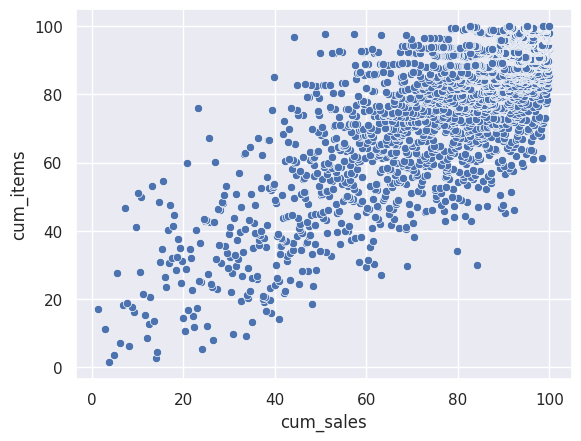

In [50]:
sns.set()
ax = sns.scatterplot(x = "cum_sales", y = "cum_items", data = abc)

plt.show()

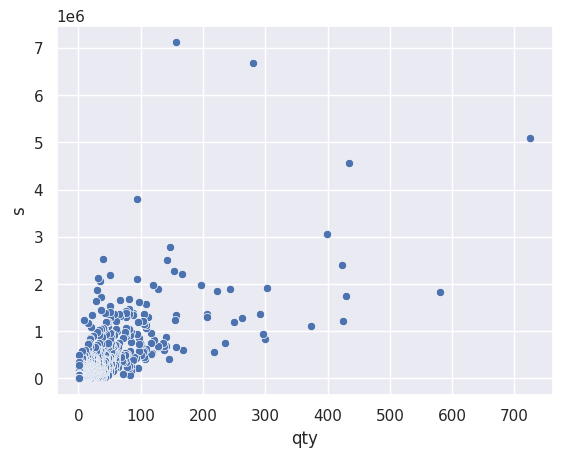

In [51]:
sns.set()
ax = sns.scatterplot(x = "qty", y = "s", data = abc)

plt.show()

Не совсем ясно как поделится кластер 3 группы, поэтому воспользуюсь k-means.

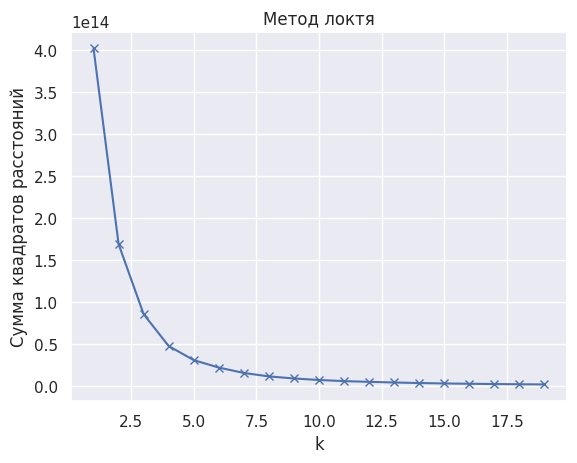

In [52]:
Sum_of_squared_distances = []
K = range(1, 20)
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(abc[["qty", "s"]])
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Сумма квадратов расстояний')
plt.title('Метод локтя')
plt.show()

Оптимальное k=5.

In [53]:
kmeans = KMeans(n_clusters = 5, random_state=0).fit(abc[["qty", "s"]])

predict = kmeans.predict(abc[["qty", "s"]])
abc['cluster'] = predict
abc.head()

,ar_id,qty,s,share_sales,share_items,cum_sales,cum_items,cluster
4743,4942,725,5092324.27,1.032901,1.536864,3.831743,1.536864,2
4713,4909,580,1823693.31,0.369909,1.229491,13.934423,2.766354,4
3366,3486,435,4566229.85,0.926190,0.922118,4.757933,3.688472,2
417,434,430,1747247.86,0.354403,0.911519,14.288826,4.599992,4
2542,2635,425,1211674.74,0.245770,0.900920,24.163885,5.500912,1


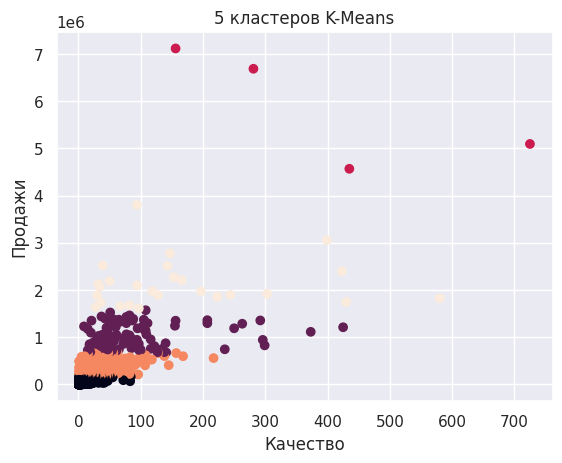

In [54]:
plt.figure('5 кластеров K-Means')
plt.scatter(abc['qty'], abc["s"], c = kmeans.labels_)
plt.xlabel('Качество')
plt.ylabel('Продажи')
plt.title('5 кластеров K-Means')
#plt.savefig('k-means_sales.png')
plt.show()

Интересно, что два кластера сильно плохо выражены, но всё же кластеры поделены нормально. В ярко-розовый кластер вошли только 4 записи.

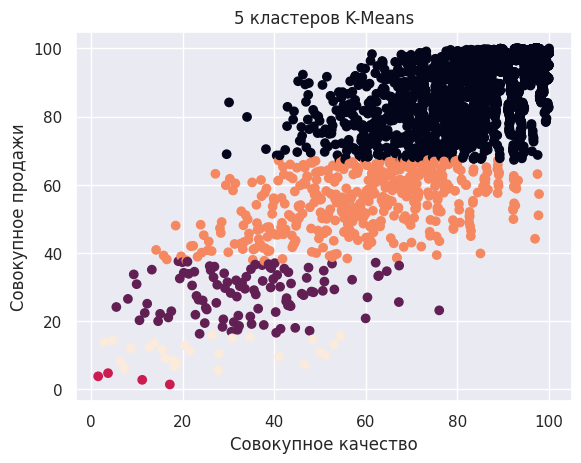

In [55]:
plt.figure('5 кластеров K-Means')
plt.scatter(abc['cum_items'], abc["cum_sales"], c = kmeans.labels_)
plt.xlabel('Совокупное качество')
plt.ylabel('Совокупное продажи')
plt.title('5 кластеров K-Means')

plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2c2d4a28-4ba0-4474-94ac-254dc4ba316c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>